# Warming Stripes with MapReduce

The *Warming Stripes* are a very simple yet effective way to visualize long-term temperature trends and to raise awareness of the global warming problem and climate crisis. 
They were introduced by British climatologist Ed Hawkins, University of Reading; see [ShowYourStripes.info](https://showyourstripes.info/s/globe). The assignment given in this notebook uses the *Warming Stripes* as an illustrative example to introduce the MapReduce programming paradigm. It assumes a basic familiarity with MapReduce and moderate experiences in Python programming. The assignment serves as a beginner's example of implementing a mapper and a reducer. It is designed by H.M. Bücker and J. Schoder, Friedrich Schiller University Jena. (Version: January 31, 2022.)
   
## Assignment Overview and Data Sets   
   
This assignment uses MapReduce to analyze and visualize temperature trends in Germany based on data offered to everybody free of charge by Germany's National Meteorological Service (DWD).
The data set used in this assignement is accessible at [Weather Data](https://opendata.dwd.de/climate_environment/CDC/regional_averages_DE/monthly/air_temperature_mean/). Please note the corresponding [copyright information](https://www.dwd.de/EN/service/copyright/copyright_node.html) provided by DWD.
   
This excercise is meant as a proof-of-concept and primarily uses rather few data points. However, the underlying algorithm and structure are applicable to much larger data sets which are studied at the end of this assignment as a bonus task.  When working with weather data, we can imagine that large data sets can easily be accumulated by using temperature data from tiny IoT weather stations from all over the world, logging the air temperature every few minutes or even seconds.   
   
Imagine that there are 193 member states as part of the United Nations. In each of these states we have, say, 100 weather stations distributed across the countryside which send their temperature data as a 32-bit single-precision floating-point number to a central server every minute. Thus, in total, we would accumulate

$$
193 \mbox{ countries} 
\cdot 100 \frac{\mbox{weather stations}}{\mbox{country}} 
\cdot 365 \frac{\mbox{days}}{\mbox{weather station}} 
\cdot  24 \frac{\mbox{hours}}{\mbox{day}} 
\cdot  60 \frac{\mbox{minutes}}{\mbox{hour}} 
\cdot   4 \frac{\mbox{Bytes}}{\mbox{year}}.
$$   
This results in 40,576,320,000 Bytes per year or about 40 GB per year.   
The problem size, of course, increases if we use smaller logging intervals or more weather stations. So, if we prefer a reasonably fast exectution time to compute the annual average temperature values for large data sets, we will eventually need to take advantage of some kind of parallelism.   
   
One attempt to employ parallelism is the MapReduce framework. The Federal Republic of Germany comprises 16 constituent states. The data consist of monthly average temperature values of different states over several decades. These values are distributed across different files storing the average temperature of one month for every year in every state. The task is to compute the annual average temperatures in Germany for all years.

An algorithm for the solution of this averaging problem is straightforwardly implemented in a general-purpose programming language. However, the MapReduce progamming model requires to reformulate algorithms in terms of mappers and reducers. The goal of this exercise is to start learning reformulating algorithms in the MapReduce progamming model.

# Preparation 1: Load Dependencies

For the first tests we just need to load the numpy and the matplotlib libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Preparation 2: Visualize the Verification Result

At first, we get the reference data from [DWD](https://opendata.dwd.de/climate_environment/CDC/regional_averages_DE/annual/air_temperature_mean/regional_averages_tm_year.txt) and store it, e.g., in a folder called ```./Data/ctl/```.

Then, we plot the already averaged temperature values for the sake of a reference solution.




In [2]:
data = np.loadtxt("Data/ctl/regional_averages_tm_year.txt", skiprows=2, delimiter=";", usecols = (0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18))
#temps_berlin_brandenburg= data[:,1]
temps = data[:,17]

tmin = temps.min() 
tmax = temps.max() 
tavg = np.average(temps)

print("Maximum Temperature: " + str(tmax))
print("Minimum Temperature: " + str(tmin))
print("Average Temperature: " + str(tavg))

## stack data to be able to plot them with imshow
stacked_temps = np.stack((temps, temps))

Maximum Temperature: 10.52
Minimum Temperature: 6.63
Average Temperature: 8.39176056338028


### Plotting Procedure

The actual plotting procedure takes the list of average temperatures of each year as a first argument. 
The second argument specifies a method for visualization with the following meaning:   

- If the parameter ```method``` is equal to 0, the color grading ranges from the average temperature of the whole time span by ± 1.5 degree Celsius.

- If the parameter ```method``` is equal to 1, the color grading ranges from the overall minimum temperature to the overall maximum temperature.

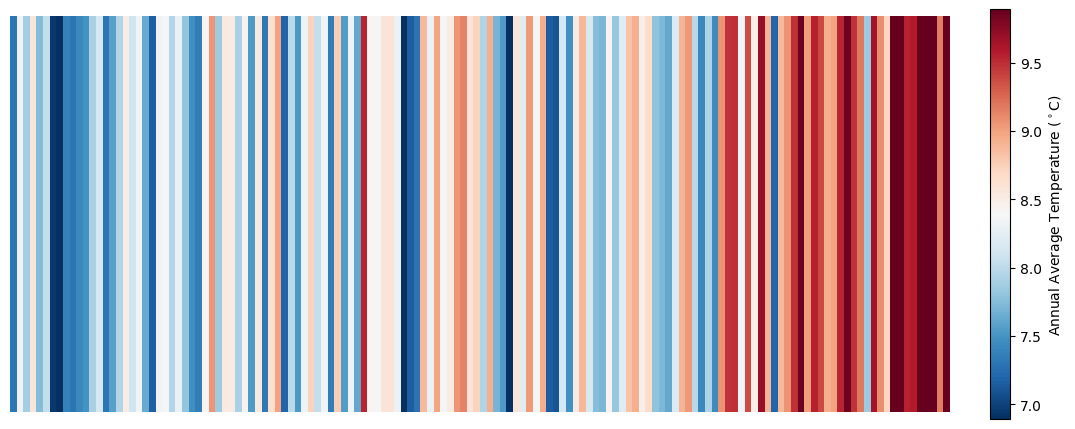

In [3]:
def plot_warming_stripes(stacked_temps, method):
    ###############
    plt.figure(figsize=(10,20))
    tavg = np.average(temps)
    if method == 0:
        #scale on average value +- 1.5 degree celcius
        vmin = tavg - 1.5
        vmax = tavg + 1.5
        img = plt.imshow(stacked_temps, cmap='RdBu_r', aspect=30, vmin=vmin, vmax=vmax)
    else: 
        #automatically scale on max and min temperature value   
        img = plt.imshow(stacked_temps, cmap='RdBu_r', aspect=30)
    
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.colorbar(img,fraction=0.0205, pad=0.04, label='Annual Average Temperature ($^\circ$C)')
    plt.savefig("stripes.png", bbox_inches = 'tight', pad_inches = 0, dpi=400)

plot_warming_stripes(stacked_temps, 0)

# Assignment Tasks: 

# Task 1: Data Aquisition

### Download the actual [DWD data set](https://opendata.dwd.de/climate_environment/CDC/regional_averages_DE/monthly/air_temperature_mean/) to the folder ```./Data/``` and inspect the files.   
There are 12 input files, one for each month. Every file contains a table with one row per year. In every row, the first column denotes the year, the second column the month of the year, and the rest of the columns give us average temperature values of different federal states in Germany of the particular month. 

There are several alternatives to the DWD data including the following: 
   - https://www.ncdc.noaa.gov/cdo-web/datasets   
   - https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data   
   - http://berkeleyearth.org/archive/analysis-code   



# Task 2: Data Preprocessing Routine
       
There are multiple options to approach our problem. We could include the necessary pre-processings steps solely into our mapper function. Our MapReduce approach would then process only this particular type of formatted input data. However, we want to keep our implementation as flexible as possible so that our map and reduce functions can be applied to any kind of data that needs to be averaged. This is the reason why we add an encapsulated pre-processing function that cleans up our data in advance, before it is processed by the mapper.

In [4]:
with open('./Data/regional_averages_tm_01.txt', 'r') as f:
    print((f.read().splitlines(True))[:3])

['Zeitreihen fuer Gebietsmittel fuer Bundeslaender und Kombinationen von Bundeslaender, erstellt am: 20231102\n', 'Jahr;Monat;Brandenburg/Berlin;Brandenburg;Baden-Wuerttemberg;Bayern;Hessen;Mecklenburg-Vorpommern;Niedersachsen;Niedersachsen/Hamburg/Bremen;Nordrhein-Westfalen;Rheinland-Pfalz;Schleswig-Holstein;Saarland;Sachsen;Sachsen-Anhalt;Thueringen/Sachsen-Anhalt;Thueringen;Deutschland;\n', '1881;01;    -5.54;    -5.56;    -4.89;    -6.51;    -5.68;    -5.07;    -4.55;    -4.55;    -4.21;    -4.49;    -4.06;    -4.15;    -6.22;    -5.89;    -6.28;    -6.76;    -5.36;\n']


For instance, we want to replace the separator ```";"``` by the separator ```"\t"``` for better readability. 
Also, as you might notice, the last column already contains the average temperature for the respective month in a year. Since we want to compute the average values ourselves, we remove this column during our pre-processing step.
The first two rows containing the table header are also stripped from the files and the second column with the information on the months is removed as well.

### Implement a pre-processing routine

In [47]:
def preprocess_features(textinput):
    lines = textinput.replace(' ', '').replace(';', '\t').splitlines()
    lines = lines[2:] # remove first two rows
    wordlines = [line.split('\t')[:-1] for line in lines] # split and remove last column
    wordlines = [words[:1] + words[2:] for words in wordlines] # remove second column
    lines = ['\t'.join(words) for words in wordlines] # join text into lines
    txt = '\n'.join(lines)
    return txt

### Let's test the routine:

In [67]:
with open('./Data/regional_averages_tm_01.txt', 'r') as f:
    data = f.read()
prep = preprocess_features(data)
#print(prep)

# Task 3: Implement the Mapper

### Now we have to write the code for the mapper function.   
What we want to do in this step is to calculate an intermediate average value for each row of the input file by averaging all of the values from individual states in Germany.  
As stated previously, every single row represents the data of one year and one month in Germany in the past for all federal states. 
The output of the mapper contains a key (the year) and a value (the average temperature of all the federal states). Recall that an input file is associated with a single month.
   
If you take the whole following code block and save it as a file named ```mapper.py``` you can use it later for the tests with Hadoop Streaming.

In [94]:
#!/usr/bin/env python

import sys 
import numpy as np

def mapper(textinput):
    #preprocess files to get data into shape
    lines = textinput.splitlines()
    lines = [line for line in lines if len(line)>0]
    wordlines = [line.split('\t') for line in lines]
    years = [words[0] for words in wordlines]
    valstrlines = [words[1:] for words in wordlines]
    valfloatlines = [[float(val) for val in vals] for vals in valstrlines]
    avgs = [sum(vals)/len(vals) for vals in valfloatlines]
    lines = [f'{years[i]}\t{avgs[i]}' for i in range(len(years))]
    returnstring = '\n'.join(lines)
    print (returnstring)
    return returnstring

mapper(sys.stdin.read())

''

Giving it a try, we see that the calculation of an average temperature for each row that the mapper gets works just fine.

In [73]:
output = mapper("Header\nHeader\n1881	01	-5.54	-5.56	-4.89	-6.51	-5.68	-5.07	-4.55	-4.55	-4.21	-4.49	-4.06	-4.15	-6.22	-5.89	-6.28	-6.76	-5.36\n1882	01	1.43	1.42	-0.65	-1.33	-0.30	1.59	1.73	1.73	1.26	-0.17	2.11	-0.04	0.63	1.18	0.60	-0.12	0.41\n1883	01	-0.41	-0.42	-0.09	-1.49	0.04	-0.69	0.33	0.32	1.27	0.49	-0.12	0.55	-1.20	-0.39	-0.69	-1.07	-0.32")

1881	-5.275625000000001
1882	0.691875
1883	-0.22312500000000002


# Task 4: Implement the Reducer

The reducers gets the key-value pairs coming out of the mappers. In our case, there are now 12 key-value pairs per year, one for each month of the year.  The reducer only has to add up every one of these and divide them by the amount ouf values (12 in our case, one for each month) to compute the annual average temperature for one year. 
   
### Write the reducer   
   
Take the whole following code block and save it as a file named ```reducer.py``` to use it later for the tests with Hadoop Streaming.

In [76]:
#!/usr/bin/env python
#Reducer.py
import sys

year_temp = {}

def reducer(textinput):
    lines = textinput.splitlines()
    lines = [line for line in lines if len(line)>0]
    wordlines = [line.split('\t') for line in lines]
    years = [words[0] for words in wordlines]
    valstrlines = [words[1:] for words in wordlines]
    valfloatlines = [[float(val) for val in vals] for vals in valstrlines]
    avgs = [sum(vals)/len(vals) for vals in valfloatlines]
    lines = [f'{years[i]}\t{avgs[i]}' for i in range(len(years))]
    returnstring = '\n'.join(lines)
    
    print(returnstring)
    return returnstring
        
reducer(sys.stdin.read())

''

# Task 5: Test the Full "Pipeline" Without Hadoop Streaming

### Tiny Test Case
In the next step, we take four example rows to see whether the computations works.

In [95]:
output = mapper(preprocess_features("Header\nHeader\n1881	02	-1.00	-1.01	1.33	-0.73	0.75	-2.01	-0.05	-0.07	1.64	1.45	-1.81	2.25	-0.92	-0.42	-0.34	-0.25	-0.10\n1881	01	-5.54	-5.56	-4.89	-6.51	-5.68	-5.07	-4.55	-4.55	-4.21	-4.49	-4.06	-4.15	-6.22	-5.89	-6.28	-6.76	-5.36\n1882	01	1.43	1.42	-0.65	-1.33	-0.30	1.59	1.73	1.73	1.26	-0.17	2.11	-0.04	0.63	1.18	0.60	-0.12	0.41\n1883	01	-0.41	-0.42	-0.09	-1.49	0.04	-0.69	0.33	0.32	1.27	0.49	-0.12	0.55	-1.20	-0.39	-0.69	-1.07	-0.32"))
output=sorted(output.split('\n'))
output='\n'.join(output)
print("Reducer Output: \n============================\n")
output = reducer(output)

1881	-0.07437499999999997
1881	-5.275625000000001
1882	0.691875
1883	-0.22312500000000002
Reducer Output: 

1881	-0.07437499999999997
1881	-5.275625000000001
1882	0.691875
1883	-0.22312500000000002


### Full Data Set

Now we test the mapper and reducer on all of our data points. To do so, we create a large list of strings from all of our input files. This list is passed to a single mapper. Later, when we are using the MapReduce framework, every mapper only gets a smaller portion of the input data and the processing is executed in parallel. But for now the tests won't run in the cluster environment.

In [96]:
import glob   
path = 'Data/regional_averages_tm_'   
inputstring = ""
files=glob.glob(path+'*.txt')   
for file in files:     
    f=open(file, 'r')  
    inputstring += preprocess_features(f.read()) + "\n"  
    f.close() 
#print(inputstring)

### Test your code using the full data set

In [98]:
def group_by_keys(textinput):
    lines = textinput.splitlines()
    wordlines = [line.split('\t') for line in lines]
    year_dict = dict()
    for year,val in wordlines:
        if year in year_dict:
            year_dict[year] += f'\t {val}'
        else:
            year_dict[year] = f'{val}'
    lines = [f'{year}\t{year_dict[year]}' for year,_ in wordlines]
    return '\n'.join(lines)

SyntaxError: invalid syntax (2633981193.py, line 1)

In [97]:
mapper_output = mapper(inputstring)
grouper_output = group_by_keys(mapper_output)
reducer_output = reducer(grouper_output)

1881	12.16823529411765
1882	13.371764705882352
1883	13.52235294117647
1884	14.430588235294117
1885	12.839411764705881
1886	15.224117647058828
1887	12.27941176470588
1888	12.562352941176472
1889	11.248235294117645
1890	13.311176470588236
1891	13.950000000000001
1892	13.856470588235295
1893	12.466470588235296
1894	11.059411764705882
1895	15.277647058823527
1896	12.86823529411765
1897	12.378823529411765
1898	13.664117647058825
1899	12.544117647058824
1900	13.80764705882353
1901	13.417647058823531
1902	12.01529411764706
1903	13.603529411764708
1904	12.028823529411763
1905	12.740588235294117
1906	12.699411764705882
1907	13.121764705882352
1908	12.231176470588236
1909	12.817058823529411
1910	12.19235294117647
1911	14.437058823529409
1912	9.28470588235294
1913	12.738235294117644
1914	12.51529411764706
1915	11.977647058823532
1916	12.078235294117647
1917	14.55529411764706
1918	12.974117647058822
1919	14.735882352941179
1920	13.069411764705885
1921	13.441176470588236
1922	11.297058823529412
192

'1881\t12.16823529411765\n1882\t13.371764705882352\n1883\t13.52235294117647\n1884\t14.430588235294117\n1885\t12.839411764705881\n1886\t15.224117647058828\n1887\t12.27941176470588\n1888\t12.562352941176472\n1889\t11.248235294117645\n1890\t13.311176470588236\n1891\t13.950000000000001\n1892\t13.856470588235295\n1893\t12.466470588235296\n1894\t11.059411764705882\n1895\t15.277647058823527\n1896\t12.86823529411765\n1897\t12.378823529411765\n1898\t13.664117647058825\n1899\t12.544117647058824\n1900\t13.80764705882353\n1901\t13.417647058823531\n1902\t12.01529411764706\n1903\t13.603529411764708\n1904\t12.028823529411763\n1905\t12.740588235294117\n1906\t12.699411764705882\n1907\t13.121764705882352\n1908\t12.231176470588236\n1909\t12.817058823529411\n1910\t12.19235294117647\n1911\t14.437058823529409\n1912\t9.28470588235294\n1913\t12.738235294117644\n1914\t12.51529411764706\n1915\t11.977647058823532\n1916\t12.078235294117647\n1917\t14.55529411764706\n1918\t12.974117647058822\n1919\t14.7358823529411

### Inspect the mapper input and output and reducer input and output. Are the results reasonable? If not, re-write the mapper and reducer.

# Task 6: Plot and Validate the Results 

### Now use the visualization function to plot our results

Maximum Temperature: 11.709333333333335
Minimum Temperature: 6.692111111111111
Average Temperature: 8.478126984126984


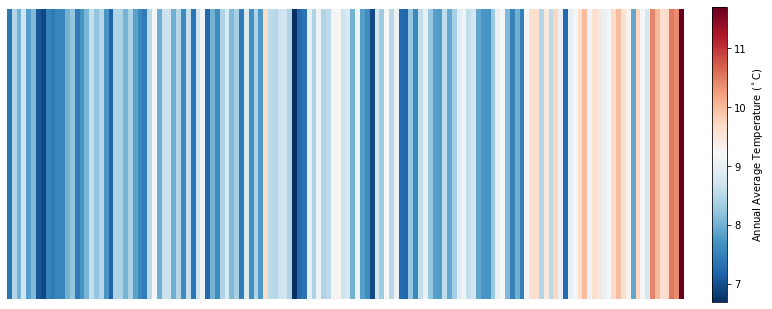

In [46]:
data = np.fromstring(output, dtype=float, sep='\t').reshape((-1, 2))
temps = data[:,1]
stacked_temps = np.stack((temps, temps))

tmin = temps.min() 
tmax = temps.max() 
tavg = np.average(temps)

print("Maximum Temperature: " + str(tmax))
print("Minimum Temperature: " + str(tmin))
print("Average Temperature: " + str(tavg))

plot_warming_stripes(stacked_temps, 1)

The result might look a bit off. Inspect the data sources and especially the last year. 
Is there an entry for every single month of the last year available? If not, remove the entire year from the plot.    
### Why is it important to check whether there is data for the whole duration of each year?   
### What are the differences between   
   - ```plot_warming_stripes(stacked_temps, 0)``` and 
   - ```plot_warming_stripes(stacked_temps, 1)```?

Maximum Temperature: 10.529166666666667
Minimum Temperature: 6.692111111111111
Average Temperature: 8.454880895283774


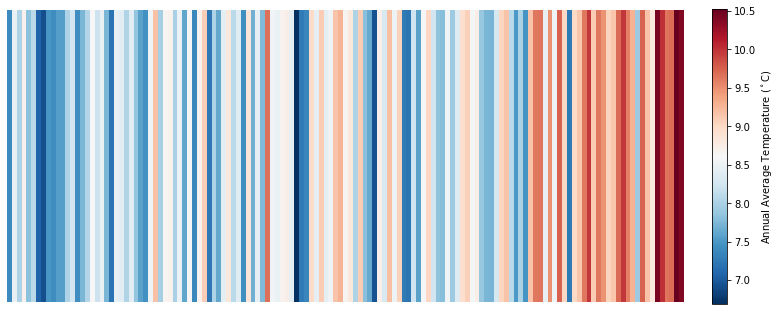

In [47]:
data = np.fromstring(output, dtype=float, sep='\t').reshape((-1, 2))
temps = data[:-1,1]
stacked_temps = np.stack((temps, temps))

tmin = temps.min() 
tmax = temps.max() 
tavg = np.average(temps)

print("Maximum Temperature: " + str(tmax))
print("Minimum Temperature: " + str(tmin))
print("Average Temperature: " + str(tavg))

plot_warming_stripes(stacked_temps, 1)

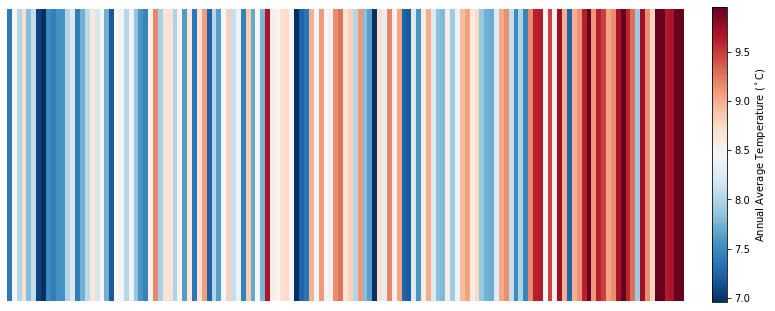

In [48]:
plot_warming_stripes(stacked_temps, 0)

# Task 7: Test Functionality with Hadoop Streaming on ARA-Cluster: 

As a last step, we copy our input data into the Hadoop Distributed File System (HDFS) into a folder called ```./Data/```  and we copy our ```mapper.py``` and ```reducer.py``` files into our Hadoop cluster.  
We can test out the code by calling: 

`time hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar -files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py -input Data -output Temp`   
   
The results can be found in the output folder ```./Temp/```  and by calling

`hdfs dfs -cat Temp/*` 

We can inspect the results and, again, plot them. 
By using Hadoop, we create one mapper for each input file. Every mapper can compute the intermediate average values separately and independently. Each mapper creates one key-value pair for ever single row in its respective input file. 
The reducer then averages all the values of the key-value pairs that share the same key. 

### Run the Code on the ARA-Cluster

# Bonus Task: Scalability

How could we enhance our example?
As stated earlier, our example can easily be expanded by just using more data points and more input files. Test out some of the other data sources given in Task 1.